In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras import backend as K
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torch
import torchvision

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
data = pd.read_csv('Dataset 1.csv', encoding = 'ISO-8859-1')

In [4]:
data

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [5]:
data = data.sample(frac = 1., random_state = 11).reset_index(drop = True)
split_val = int(0.2 * data.shape[0])
dataTest = data.iloc[-split_val :]
dataVal = data.iloc[- 2 * split_val : -split_val]
dataTrain = data.iloc[: - 2 * split_val]

In [6]:
trainX = np.array(dataTrain.iloc[:, 0])
trainY = np.array(dataTrain.iloc[:, 1])
valX = np.array(dataVal.iloc[:, 0])
valY = np.array(dataVal.iloc[:, 1])
testX = np.array(dataTest.iloc[:, 0])
testY = np.array(dataTest.iloc[:, 1])

In [7]:
n = 50000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = n, oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(trainX)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(trainX)
val_seqs = tokenizer.texts_to_sequences(valX)
test_seqs = tokenizer.texts_to_sequences(testX)
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding = 'pre')
val_seqs = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding = 'pre')
test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding = 'pre')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2082944   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         65792     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          32832     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0

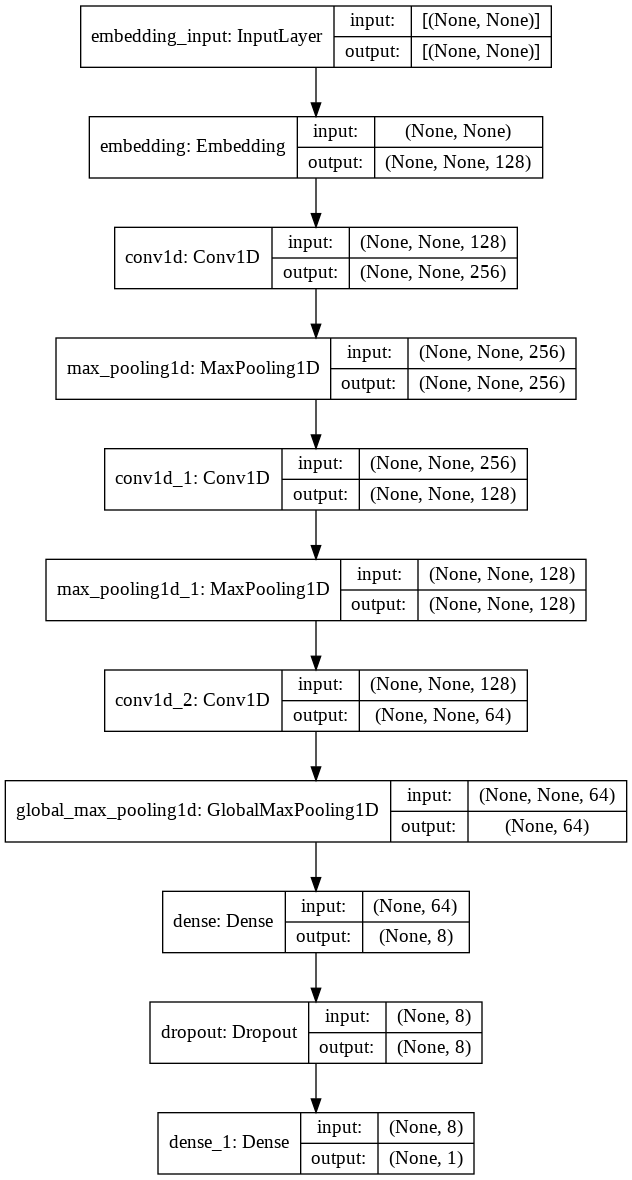

In [8]:
model = Sequential()
model.add(layers.Embedding(len(tokenizer.word_index), 128))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling1D(pool_size = 2))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size = 2))
model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary() 

tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

Epoch 1/5
194/194 [==============================] - 15s 73ms/step - loss: 0.3576 - accuracy: 0.8583 - val_loss: 0.1160 - val_accuracy: 0.9680
Epoch 2/5
194/194 [==============================] - 14s 72ms/step - loss: 0.1017 - accuracy: 0.9756 - val_loss: 0.1372 - val_accuracy: 0.9617
Epoch 3/5
194/194 [==============================] - 14s 72ms/step - loss: 0.0488 - accuracy: 0.9903 - val_loss: 0.2215 - val_accuracy: 0.9403
Epoch 4/5
194/194 [==============================] - 14s 73ms/step - loss: 0.0318 - accuracy: 0.9955 - val_loss: 0.3850 - val_accuracy: 0.9214
Epoch 5/5
194/194 [==============================] - 14s 72ms/step - loss: 0.0366 - accuracy: 0.9937 - val_loss: 0.2395 - val_accuracy: 0.9680


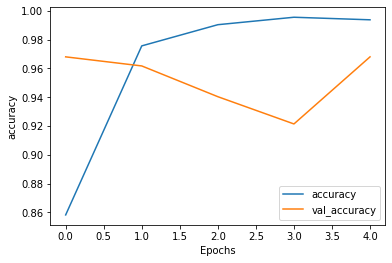

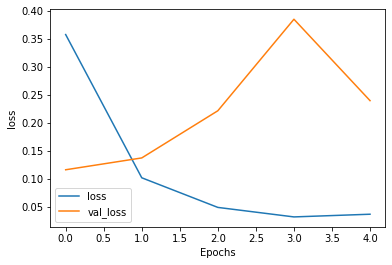


Epoch No.  Train Accuracy  Train Loss     Val Accuracy    Val Loss
       1   0.858320 	   0.357590 	   0.967992 	   0.116045
       2   0.975606 	   0.101723 	   0.961688 	   0.137189
       3   0.990307 	   0.048784 	   0.940349 	   0.221478
       4   0.995477 	   0.031807 	   0.921435 	   0.384950
       5   0.993699 	   0.036618 	   0.967992 	   0.239531


In [9]:
EPOCH = 5
history = model.fit(train_seqs, trainY, epochs = EPOCH, validation_data = (val_seqs, valY), verbose = 1)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

print('\nEpoch No.  Train Accuracy  Train Loss     Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history.history['accuracy'][i], history.history['loss'][i], history.history['val_accuracy'][i], history.history['val_loss'][i]))

194/194 [==============================] - 3s 15ms/step - loss: 0.0135 - accuracy: 0.9960
Train Loss: 0.013541028834879398
Train Accuracy: 0.9959612488746643 (Model Metric)
Train Accuracy: 0.9959612277867528 (sklearn Metric)
Train Precision: 0.9992673992673993
Train Recall: 0.9827089337175793
Train F1-score: 0.9909189974573193


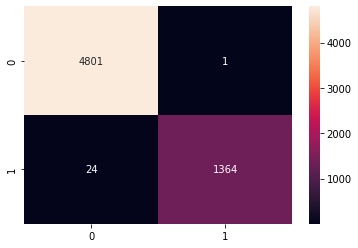

In [10]:
y_pred = model.predict(train_seqs)

y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = model.evaluate(train_seqs, trainY, verbose = 1)
print('Train Loss:', loss)
print('Train Accuracy:', accuracy, '(Model Metric)')
print('Train Accuracy:', accuracy_score(trainY, y_pred), '(sklearn Metric)')
print('Train Precision:', precision_score(trainY, y_pred))
print('Train Recall:', recall_score(trainY, y_pred))
print('Train F1-score:', f1_score(trainY, y_pred))

sns.heatmap(confusion_matrix(trainY, y_pred), annot = True, fmt = 'g')

65/65 [==============================] - 1s 12ms/step - loss: 0.2395 - accuracy: 0.9680
Validation Loss: 0.2395308017730713
Validation Accuracy: 0.9679922461509705 (Model Metric)
Validation Accuracy: 0.967992240543162 (sklearn Metric)
Validation Precision: 0.9690949227373068
Validation Recall: 0.8940936863543788
Validation F1-score: 0.9300847457627118


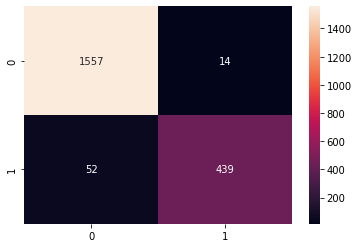

In [11]:
y_pred = model.predict(val_seqs)

y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = model.evaluate(val_seqs, valY, verbose = 1)
print('Validation Loss:', loss)
print('Validation Accuracy:', accuracy, '(Model Metric)')
print('Validation Accuracy:', accuracy_score(valY, y_pred), '(sklearn Metric)')
print('Validation Precision:', precision_score(valY, y_pred))
print('Validation Recall:', recall_score(valY, y_pred))
print('Validation F1-score:', f1_score(valY, y_pred))

sns.heatmap(confusion_matrix(valY, y_pred), annot = True, fmt = 'g')

65/65 [==============================] - 1s 16ms/step - loss: 0.1282 - accuracy: 0.9796
Test Loss: 0.12819597125053406
Test Accuracy: 0.9796314239501953 (Model Metric)
Test Accuracy: 0.979631425800194 (sklearn Metric)
Test Precision: 0.9667458432304038
Test Recall: 0.9356321839080459
Test F1-score: 0.9509345794392523


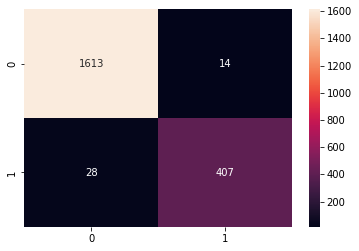

In [12]:
y_pred = model.predict(test_seqs)

y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.reshape(y_pred, (y_pred.shape[0]))

loss, accuracy = model.evaluate(test_seqs, testY, verbose = 1)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy, '(Model Metric)')
print('Test Accuracy:', accuracy_score(testY, y_pred), '(sklearn Metric)')
print('Test Precision:', precision_score(testY, y_pred))
print('Test Recall:', recall_score(testY, y_pred))
print('Test F1-score:', f1_score(testY, y_pred))

sns.heatmap(confusion_matrix(testY, y_pred), annot = True, fmt = 'g')